In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import uuid
import time

def generate_face_id(num_char=8):
    return uuid.uuid4().hex[:num_char]

In [3]:
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from IPython.display import display

def image_to_face(image, min_face_size=20, threshold_p_val=0.9, device='cpu'):
    mtcnn = MTCNN(keep_all=True, min_face_size=min_face_size, device=device)
    transform = transforms.ToTensor()

    bounds, p_vals = mtcnn.detect(image)

    threshold_p_val = threshold_p_val
    valid_bounds = []
    valid_p_vals = []
    if bounds is not None:
        for box, p_val in zip(bounds, p_vals):
            if p_val > threshold_p_val:
                valid_bounds.append(box)
                valid_p_vals.append(p_val)

    face_tensors = []
    boundary_boxs = []
    if valid_bounds is not None:
        for i, box in enumerate(valid_bounds):
            (box[0], box[1], box[2], box[3]) = (box[0] - 20, box[1] - 30,
                                                     box[2] + 20, box[3] + 20)
            face = image.crop(tuple(box))
            face_tensor = transform(face).to(device)

            face_tensors.append(face_tensor)
            boundary_boxs.append(box)

    return face_tensors, boundary_boxs, valid_p_vals

In [4]:
def face_tensor_to_embedding(face_tensor, resnet_model='vggface2', device='cpu'):
    resnet = InceptionResnetV1(pretrained=resnet_model, device=device).eval()

    with torch.inference_mode():
        face_embedding = resnet(face_tensor.unsqueeze(0))

    return face_embedding.cpu()

In [5]:
def image_to_face_list(image_path):
    image = Image.open(image_path)

    face_list = []

    face_tensors, bounds, p_vals = image_to_face(image)

    for i, face_tensor in enumerate(face_tensors):
        face_embedding = face_tensor_to_embedding(face_tensor)
        face_id = generate_face_id()

        face_dict = dict()

        face_dict['id'] = face_id
        face_dict['embedding'] = face_embedding
        face_dict['boundary_box'] = bounds[i]
        face_dict['probability'] = p_vals[i]

        face_list.append(face_dict)

    return face_list

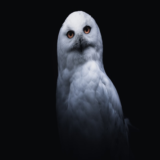

torch.Size([1, 3, 160, 160])
<class 'torch.Tensor'>


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [20]:
import torch
from PIL import Image
from torchvision import transforms
from image_to_list_of_dict import create_unlabel_dataloader
from facenet_pytorch import MTCNN
from IPython.display import display

# Set up the image directory and dataloader
image_dir = "/home/sajid/Work/ResilientSage/FaceNet/unsplash_face"
dataloader = create_unlabel_dataloader(image_dir, image_size=(160, 160), batch_size=32, num_workers=4)

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True, min_face_size=5)

# Loop through the dataloader to display images and detect faces
for images, _ in dataloader:
    for image in images:
        # Convert the tensor to a PIL image
        image_np = image.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        image_np = (image_np * 255).byte().numpy()  # Convert to a numpy array with values in [0, 255]

        # Create a PIL image
        img = Image.fromarray(image_np)

        # Display the image
        display(img)

        # Detect faces (need to unsqueeze to make it 4D for batch processing)
        image = image.unsqueeze(0)
        print(image.shape)
        print(type(image))
        boxes, _ = mtcnn.detect(image)  # shape should be (1, C, H, W)
        print(type(image))

        if boxes is not None:
            print("Detected boxes:", boxes)  # Print detected bounding boxes
        else:
            print("No faces detected.")  # Handle the case where no faces are detected


In [21]:
import torch
from PIL import Image
from torchvision import transforms
from facenet_pytorch import MTCNN

# Initialize MTCNN
mtcnn = MTCNN(keep_all=True)

# Load an image using PIL
image_path = '/home/sajid/Work/ResilientSage/FaceNet/unsplash_face2LdvigX5xkc.jpg'  # Replace with your image path
img = Image.open(image_path)

# Define a transform to convert the image to a tensor
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize to desired dimensions
    transforms.ToTensor(),  # Convert to tensor
])

# Apply the transform
img_tensor = transform(img)  # Now img_tensor is of shape (C, H, W)

# Unsqueeze to add a batch dimension (N, C, H, W)
img_tensor = img_tensor.unsqueeze(0)  # Now img_tensor is of shape (1, C, H, W)

# Detect faces in the image
boxes, points = mtcnn.detect(img_tensor)

# Check the results
if boxes is not None:
    print("Detected boxes:", boxes)
else:
    print("No faces detected.")


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [23]:
from image_to_list_of_dict import create_unlabel_dataloader, detect_face, create_face_embedding, create_json

In [25]:
import json

# Example list of dictionaries
list_of_dicts = [
    {"name": "Alice", "age": 25, "city": "New York"},
    {"name": "Bob", "age": 30, "city": "San Francisco"},
    {"name": "Charlie", "age": 35, "city": "Chicago"}
]

# Convert list of dictionaries to JSON
json_data = json.dumps(list_of_dicts, indent=4)

# Write JSON data to a file
# with open('output.json', 'w') as f:
#     f.write(json_data)

print(json_data)

[
    {
        "name": "Alice",
        "age": 25,
        "city": "New York"
    },
    {
        "name": "Bob",
        "age": 30,
        "city": "San Francisco"
    },
    {
        "name": "Charlie",
        "age": 35,
        "city": "Chicago"
    }
]
